<a href="https://colab.research.google.com/github/adenning-1/QNC-2025/blob/main/Multiple_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neuroscience/blob/master/Concepts/Python/Multiple%20Comparisons.ipynb)

# Definitions

The multiple comparisons problem in statistics occurs when multiple statistical inferences are done simultaneously, which greatly increases the probability that any one inference will yield an erroneous result, by chance. A lot has been written about this problem, including:

- [Its prevalence in fMRI data analysis](https://www.sciencedirect.com/science/article/pii/S1053811912007057?via%3Dihub) (including a compelling illustration by this [prizewinning study](https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/)\)

- [How Baysian methods can avoid the problem](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf).

- [General approaches for correcting for multiple comparisons](http://www.biostathandbook.com/multiplecomparisons.html).

Here we will provide some intuition for the problem using a simple thought experiment, to sensitize you to how much of a problem it can be. Consider performing the same statistical test on *N* different samples corresponding to, say, different voxels in fMRI data, using a *p*-value of $\alpha$ (typically 0.05) for each test.

Thus, for any one test, the probability of getting a Type I error (rejecting $H_0$ when $H_0$ is true) is $\alpha$:

$p_{error}=\alpha$

For two tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from either one:

$p_{error}=1-(1-\alpha)(1-\alpha)$

For *N* tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from any one:

$p_{error}=1-(1-\alpha)^N$

Run the cell below to see that the probability of getting a Type I error under these conditions grows rapidly with *N*, implying that it becomes very, very likely that you will get a "statistically significant result" just by chance if you do enough tests:

Text(0, 0.5, '$P_{error}$')

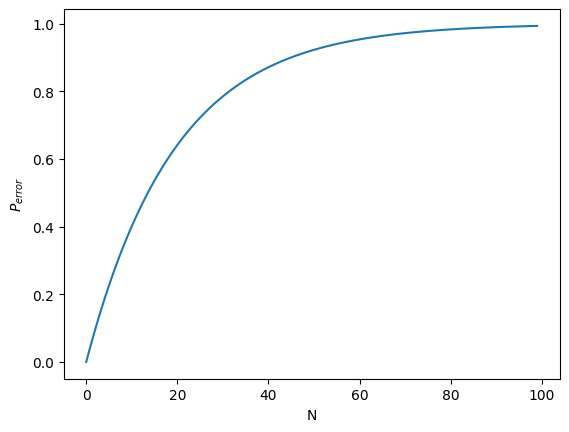

In [1]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.05
N = np.arange(0,100)
plt.plot(N, 1-(1-alpha)**N)
plt.xlabel('N')
plt.ylabel('$P_{error}$')

# Correcting for multiple comparisons



There are a number of different methods that can be used to [correct for this problem](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/). Below are two common methods.




## Bonferroni correction

The simplest way to correct for Type I errors (false positives) in multiple comparisons is to divide $\alpha$ by the number of comparisons, known as the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html). This is a very conservative test that is typically used when the number of comparisons is relatively small and you want to avoid Type I errors.

## Benjamini–Hochberg procedure


Another approach is to more carefully control the false-discovery rate using the [Benjamini–Hochberg procedure](https://www.jstor.org/stable/2346101?seq=1#metadata_info_tab_contents):

1\. Rank the individual *p*-values in ascending order, labeled *i*=1...*n*

2\. For each *p*-value, calculate its "critical value" as (*i*/*n*)*Q*, where *i* is the rank, *n* is the total number of tests, and *Q* is the false discovery rate (a percentage) that you choose (typically 0.05).

3\. In your rank-ordered, original *p*-values, find the largest value that is smaller than its associated critical value; this *p*-value is the new criterion (i.e., reject $H_0$ for all cases for which *p* ≤ this value).

# Exercise

In this exercise we will run through an example of correcting for multiple comparisons with both the Benjamini-Hochberg procedure and the more conservative Bonferroni correction.

First, simulate multiple (say, 1000) t-tests comparing two samples with equal means and standard deviations, and save the p-values. Obviously, at p<0.05 we expect that ~5% of the simulations to yield a "statistically significant" result (of rejecting the NULL hypothesis that the samples come from distributions with equal means).

Second, once you have the simulated p-values, apply both methods to address the multiple comparisons problem.

Third, set the sample 1 and sample 2 means to be 1 and 2 respectively, and re-run the exercise. What do you notice? What if you make the difference between means even greater?

In [2]:
import numpy as np
import scipy.stats as st


n_ttests = 1000 # Number of t-tests to run
mu = 1 # true mean
sd = 0.5 # true sd
n_sims = 1000 # N in each sample

pvalues = [] # Initialize

# Generate p-values
for n in range(n_ttests):
    sample1 = np.random.normal(loc = mu, scale = sd, size = n_sims)
    sample2 = np.random.normal(loc = mu, scale = sd, size = n_sims)
    _, p_value = st.ttest_ind(sample1, sample2)
    pvalues.append(p_value)


Number of simulations that are 'statistically significant at alpha = 0.05': 
 61 out of 1000, or 6.1%


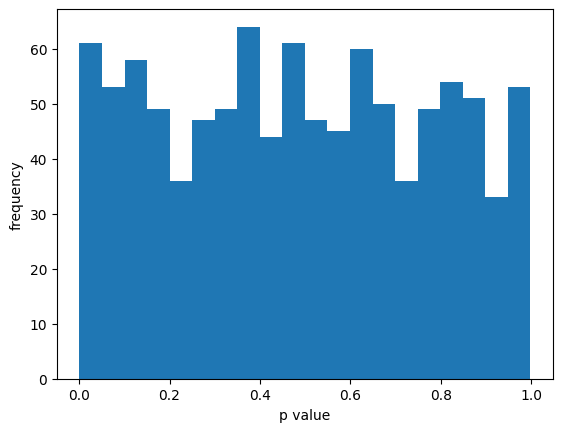

In [3]:
# Plot to visualize the frequency of the p-values
plt.hist(pvalues, bins = 20)
plt.xlabel("p value")
plt.ylabel("frequency")
alpha = 0.05

pvalues = np.array(pvalues)

# Count how many are less than 5%
print(f"Number of simulations that are 'statistically significant at alpha = {alpha}': \n {sum(pvalues < alpha)} out of {n_ttests}, or {sum(pvalues < alpha) / n_ttests * 100}%")

In [4]:
# Bonferroni
alpha_bonf = alpha / n_ttests
print(f"Number of simulations that are 'statistically significant at Bonferoni corrected alpha = {alpha_bonf}': \n  {sum(pvalues < alpha_bonf)} out of {n_ttests}, or {sum(pvalues < alpha_bonf) / n_ttests * 100}%")


Number of simulations that are 'statistically significant at Bonferoni corrected alpha = 5e-05': 
  0 out of 1000, or 0.0%


In [5]:
# Benjamini–Hochberg procedure
# Sort
pvalues_sorted = np.sort(pvalues)
# Loop thorugh each p value
n = n_ttests # total number of tests
Q = 0.05
BH_critical = []
criterion = 0
for indx in range(len(pvalues_sorted)):
  # calculate critical index
  pval = pvalues_sorted[indx] # get the p value
  #print("p value", pval)
  i = indx + 1 # get it's rank (pvalues is now in order, add 1 because python indexes base 0)
  critical_value = (i/n)*Q
  #print("critical value", critical_value)
  BH_critical.append(critical_value)
  # Check if pvalue is smaller than critical
  difference = critical_value - pval
  #print("difference: ", difference)
  # If the difference is positive (pvalue smaller)
  if (difference > 0):
    # if the pvalue is bigger than criterion, replace criterion
    if(pval > criterion):
      criterion = pval


# Now count how many p values are less than criterion
print(f"Number of simulations that are statistically significant after Benjami-Hochberg procedure: \n  {sum(pvalues < criterion)} out of {n_ttests}, or {sum(pvalues < criterion) / n_ttests  * 100}%")





Number of simulations that are statistically significant after Benjami-Hochberg procedure: 
  0 out of 1000, or 0.0%


In [6]:
# Define a function to do this with any given sample mean
def multiple_comparisons_exercise(mean1, mean2, sd, n_ttests, alpha):
  print(f"sample 1 mean: {mean1}, sample 2 mean: {mean2}")

  pvalues = []

  # Generate p-values
  for n in range(n_ttests):
      sample1 = np.random.normal(loc = mean1, scale = sd, size = 1000)
      sample2 = np.random.normal(loc = mean2, scale = sd, size = 1000)
      _, p_value = st.ttest_ind(sample1, sample2)
      pvalues.append(p_value)
  pvalues = np.array(pvalues)

  # Count how many are less than 5%
  print(f"Number of simulations that are 'statistically significant at alpha = {alpha}': \n {sum(pvalues < alpha)} out of {n_ttests}, or {sum(pvalues < alpha) / n_ttests * 100}%")

  # Bonferroni
  alpha_bonf = alpha / n_ttests
  print(f"Number of simulations that are 'statistically significant at Bonferoni corrected alpha = {alpha_bonf}': \n  {sum(pvalues < alpha_bonf)} out of {n_ttests}, or {sum(pvalues < alpha_bonf) / n_ttests * 100}%")

  # Benjamini–Hochberg procedure
  # Sort
  pvalues_sorted = np.sort(pvalues)
  # Loop thorugh each p value
  n = n_ttests # total number of tests
  Q = 0.05
  BH_critical = []
  criterion = 0
  for indx in range(len(pvalues_sorted)):
    # calculate critical index
    pval = pvalues_sorted[indx] # get the p value
    #print("p value", pval)
    i = indx + 1 # get it's rank (pvalues is now in order, add 1 because python indexes base 0)
    critical_value = (i/n)*Q
    #print("critical value", critical_value)
    BH_critical.append(critical_value)
    # if the pval is smaller than the critical, rewrite the criteron (this will always be the highest p that does because we are looping ascending)
    if pval <= critical_value:
      criterion = pval


  # Now count how many p values are less than criterion
  print(f"Number of simulations that are statistically significant after Benjami-Hochberg procedure: \n  {sum(pvalues <= criterion)} out of {n_ttests}, or {sum(pvalues <= criterion) / n_ttests * 100}% \n")




In [7]:

multiple_comparisons_exercise(mean1 = 1,
                              mean2 = 1,
                              sd = 10,
                              n_ttests = 1000,
                              alpha = 0.05)
multiple_comparisons_exercise(mean1 = 1,
                              mean2 = 2,
                              sd = 10,
                              n_ttests = 1000,
                              alpha = 0.05)
multiple_comparisons_exercise(mean1 = 1,
                              mean2 = 3,
                              sd = 10,
                              n_ttests = 1000,
                              alpha = 0.05)
multiple_comparisons_exercise(mean1 = 1,
                              mean2 = 4,
                              sd = 10,
                              n_ttests = 1000,
                              alpha = 0.05)


sample 1 mean: 1, sample 2 mean: 1
Number of simulations that are 'statistically significant at alpha = 0.05': 
 54 out of 1000, or 5.4%
Number of simulations that are 'statistically significant at Bonferoni corrected alpha = 5e-05': 
  0 out of 1000, or 0.0%
Number of simulations that are statistically significant after Benjami-Hochberg procedure: 
  0 out of 1000, or 0.0% 

sample 1 mean: 1, sample 2 mean: 2
Number of simulations that are 'statistically significant at alpha = 0.05': 
 621 out of 1000, or 62.1%
Number of simulations that are 'statistically significant at Bonferoni corrected alpha = 5e-05': 
  34 out of 1000, or 3.4000000000000004%
Number of simulations that are statistically significant after Benjami-Hochberg procedure: 
  521 out of 1000, or 52.1% 

sample 1 mean: 1, sample 2 mean: 3
Number of simulations that are 'statistically significant at alpha = 0.05': 
 997 out of 1000, or 99.7%
Number of simulations that are 'statistically significant at Bonferoni corrected a

As the difference in the mean gets larger, the two approaches are similar. With no true difference in mean, both methods show no significant results. With a small difference in means, Bonferroni correction is much stricter, and only 34 simulations are significant compared to 521 for BH correction. As the difference in means increases, both methods produce a higher proportion of simulations considered statistically significant. This result shows that Bonferroni correction is much stricter with a small difference in means than BH correction.

# Additional Resources


How to correct for multiple comparisons in [Matlab](https://www.mathworks.com/help/stats/multcompare.html), [R](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/p.adjust.html), and [Python](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)

# Credits

Copyright 2021 by Joshua I. Gold, University of Pennsylvania